In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

#  VAE Components 
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder 

latent_dim = 32
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder 

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# VAE Model with Custom Training Step 

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Load and Preprocess the Data 

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data() 
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# Train the VAE 

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=30, batch_size=128)




Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 14, 14,    │        320 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 7, 7, 64)  │     18,496 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 3136)      │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │     50,192 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │        544 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │        544 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_5          │ (None, 32)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,096 (273.81 KB)

 Trainable params: 70,096 (273.81 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - kl_loss: 6.7915 - loss: 237.9577 - reconstruction_loss: 231.1662
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - kl_loss: 16.1430 - loss: 142.2945 - reconstruction_loss: 126.1514
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 15.4915 - loss: 130.1554 - reconstruction_loss: 114.6639
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 14.9164 - loss: 124.3586 - reconstruction_loss: 109.4422
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 15.0260 - loss: 120.5482 - reconstruction_loss: 105.5222
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 15.2737 - loss: 118.3793 - reconstruction_loss: 103.1056
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 15.4246 - loss: 116.6137 - reconstruction_loss: 101.1890
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 15.4239 - loss: 115.5184 - reconstruction_loss: 100.0945
Epoch 9/30
547/547 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


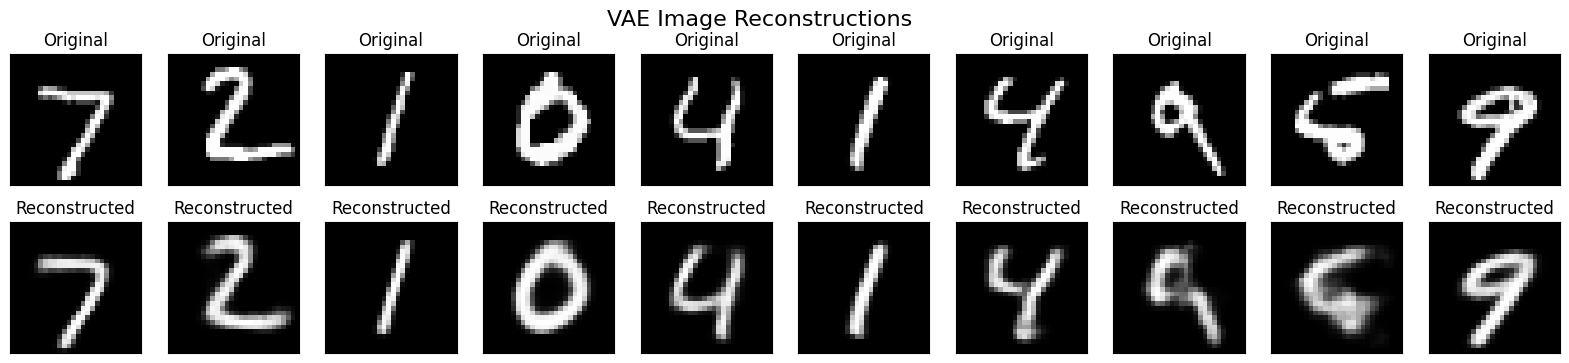

In [ ]:
# Evaluate and Reconstruct Images 
def plot_reconstructions(model, data, n_images=10):
    _, _, z = model.encoder.predict(data)
    reconstructions = model.decoder.predict(z)
    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Original")
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Reconstructed")
    plt.suptitle("VAE Image Reconstructions", fontsize=16)
    plt.show()


# Reload test data to get labels for visualization
(_, _), (x_test_vis, y_test_vis) = keras.datasets.mnist.load_data()
x_test_vis_norm = np.expand_dims(x_test_vis, -1).astype("float32") / 255

plot_reconstructions(vae, x_test_vis_norm[:10])


### VAE generating from noise vector


Generating 5 images from 32-dimensional noise vectors...
Noise Distribution: Mean=5.0, Variance=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


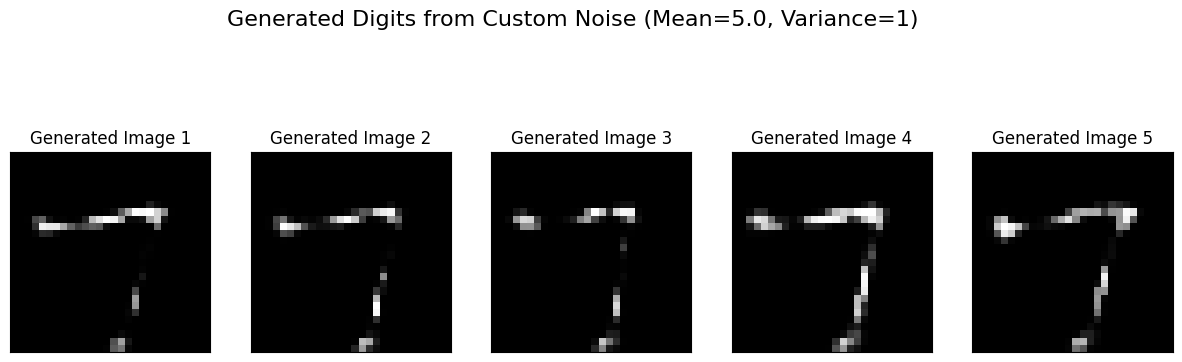

In [ ]:
# Generate Images from Custom Noise 

def generate_from_custom_noise(vae, n_images=5, mean=5.0, stddev=1.0):

    # Get the latent dimension from the trained model's encoder
    latent_dim = vae.encoder.get_layer('z_mean').output.shape[-1]
    
    print(f"\nGenerating {n_images} images from {latent_dim}-dimensional noise vectors...")
    print(f"Noise Distribution: Mean={mean}, Variance={stddev**2}")

    # enerate five noise vectors from the specified normal distribution
    random_latent_vectors = tf.random.normal(
        shape=(n_images, latent_dim), mean=mean, stddev=stddev
    )
    
    # Pass the noise through the decoder to generate images
    generated_images = vae.decoder.predict(random_latent_vectors)
    
    # Create the visualization for the generated images
    plt.figure(figsize=(15, 5))
    
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f"Generated Image {i+1}")
        
    plt.suptitle(f"Generated Digits from Custom Noise (Mean={mean}, Variance=1)", fontsize=16)
    plt.show()


# Generate 5 new images from custom noise with mean=5 and variance=1 (stddev=1)
generate_from_custom_noise(vae, n_images=5, mean=5.0, stddev=1.0)


Generating 5 images from 32-dimensional noise vectors...
Noise Distribution: Mean=0.0, Variance=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


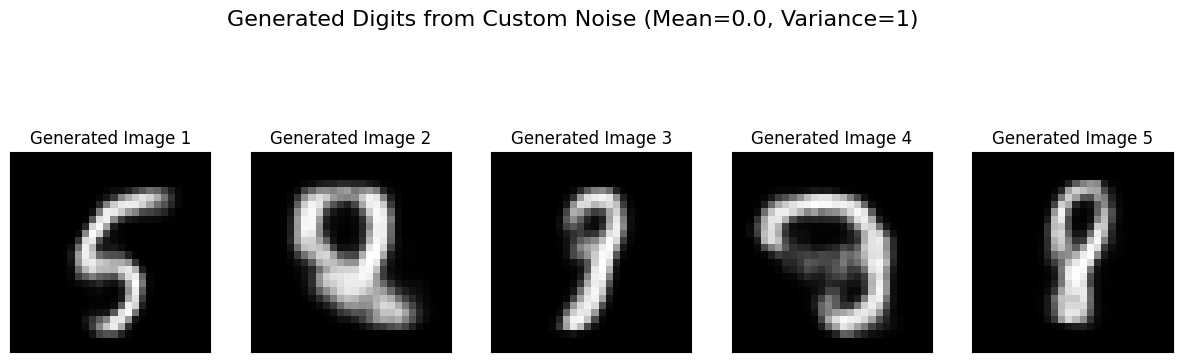

In [15]:
generate_from_custom_noise(vae, n_images=5, mean=0.0, stddev=1.0)